In [1]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install python-gdcm
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg==2.2.0
!pip install pylibjpeg-openjpeg==2.3.0
!pip install matplotlib==3.10.3
!pip install scikit-learn==1.7.0

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
from pathlib import Path
import logging

In [19]:
train_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv'\
                              , low_memory=True)

train_locale_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv'\
                              , low_memory=True)

In [6]:
print("Train CSV shape : ", train_meta_data.shape)
print("Train Localizers CSV shape : ", train_locale_meta_data.shape)

Train CSV shape :  (4405, 18)
Train Localizers CSV shape :  (2286, 4)


In [7]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

train_meta_data.head(10)

SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.10004044428023505108375152878107656647""",64,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10004684224894397679901841656954650085""",76,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.10009383108068795488741533244914370182""",71,"""Male""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10012790035410518400400834395242853657""",48,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10014757658335054766479957992112625961""",53,"""Female""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10021411248005513321236647460239137906""",55,"""Female""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10022688097731894079510930966432818105""",51,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831""",78,"""Male""","""CTA""",0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [9]:
train_locale_meta_data.head(10)

SeriesInstanceUID,SOPInstanceUID,coordinates,location
str,str,str,str
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346""","""{'x': 258.3621186176837, 'y': 261.359900373599}""","""Other Posterior Circulation"""
"""1.2.826.0.1.3680043.8.498.10022796280698534221758473208024838831""","""1.2.826.0.1.3680043.8.498.53868409774237283281776807176852774246""","""{'x': 194.87253141831238, 'y': 178.32675044883302}""","""Right Middle Cerebral Artery"""
"""1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636""","""1.2.826.0.1.3680043.8.498.24186535344744886473554579401056227253""","""{'x': 189.23979878597123, 'y': 209.19184886465828}""","""Right Middle Cerebral Artery"""
"""1.2.826.0.1.3680043.8.498.10030095840917973694487307992374923817""","""1.2.826.0.1.3680043.8.498.75217084841854214544099244823406151875""","""{'x': 208.2805049088359, 'y': 229.78962131837307}""","""Right Infraclinoid Internal Carotid Artery"""
"""1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557""","""1.2.826.0.1.3680043.8.498.71237104731452368587327801789352569583""","""{'x': 249.86745590416498, 'y': 220.623044646393}""","""Anterior Communicating Artery"""
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.30083322134992576720636296296008654053""","""{'x': 223.66020358711827, 'y': 225.3447011195274}""","""Right Anterior Cerebral Artery"""
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.46752468449107005352755579756056225731""","""{'x': 289.2376764288231, 'y': 211.78100912436958}""","""Left Middle Cerebral Artery"""
"""1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381""","""1.2.826.0.1.3680043.8.498.14504961303532677815336995545201912867""","""{'x': 232.88987039309842, 'y': 226.4305401310092}""","""Right Supraclinoid Internal Carotid Artery"""
"""1.2.826.0.1.3680043.8.498.10042423585566957032411171949972906248""","""1.2.826.0.1.3680043.8.498.63062558671948377310688873437936911318""","""{'x': 140.1086940862857, 'y': 177.63838968827815}""","""Right Middle Cerebral Artery"""


In [20]:
import json

def parse_coordinates(coord_str):
    if coord_str is None:
        return None, None
    try:
        coord_dict = json.loads(coord_str.replace("'", '"'))
        return float(coord_dict.get('x', 0.0)), float(coord_dict.get('y', 0.0))
    except (json.JSONDecodeError, KeyError, ValueError, AttributeError):
        return None, None

train_locale_meta_data = train_locale_meta_data.with_columns([
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[0], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_x"),
    
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[1], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_y")
])

# Show the first few rows
print(train_locale_meta_data.select(["coordinates", "coordinates_x", "coordinates_y"]).head(5))

shape: (5, 3)
┌────────────────────────────────────────────────────┬───────────────┬───────────────┐
│ coordinates                                        ┆ coordinates_x ┆ coordinates_y │
│ ---                                                ┆ ---           ┆ ---           │
│ str                                                ┆ f64           ┆ f64           │
╞════════════════════════════════════════════════════╪═══════════════╪═══════════════╡
│ {'x': 258.3621186176837, 'y': 261.359900373599}    ┆ 258.362119    ┆ 261.3599      │
│ {'x': 194.87253141831238, 'y': 178.32675044883302} ┆ 194.872531    ┆ 178.32675     │
│ {'x': 189.23979878597123, 'y': 209.19184886465828} ┆ 189.239799    ┆ 209.191849    │
│ {'x': 208.2805049088359, 'y': 229.78962131837307}  ┆ 208.280505    ┆ 229.789621    │
│ {'x': 249.86745590416498, 'y': 220.623044646393}   ┆ 249.867456    ┆ 220.623045    │
└────────────────────────────────────────────────────┴───────────────┴───────────────┘


In [24]:
# Get summary statistics of the new columns
print(train_locale_meta_data.select(["coordinates_x", "coordinates_y"]).describe())

shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ coordinates_x ┆ coordinates_y │
│ ---        ┆ ---           ┆ ---           │
│ str        ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ count      ┆ 2286.0        ┆ 2286.0        │
│ null_count ┆ 0.0           ┆ 0.0           │
│ mean       ┆ 250.984879    ┆ 215.891834    │
│ std        ┆ 68.854384     ┆ 53.991792     │
│ min        ┆ 0.339623      ┆ 5.0           │
│ 25%        ┆ 219.367003    ┆ 190.429365    │
│ 50%        ┆ 253.486724    ┆ 211.051486    │
│ 75%        ┆ 280.620123    ┆ 233.006627    │
│ max        ┆ 714.748844    ┆ 583.68        │
└────────────┴───────────────┴───────────────┘


In [8]:
def create_df_from_directory(main_folder_path, file_extension=".dcm"):
    main_path = Path(main_folder_path)
    
    if not main_path.exists():
        raise ValueError(f"Directory not found: {main_folder_path}")
    
    data = []
    
    try:
        # Get list of subfolders first to show progress
        subfolders = [f for f in main_path.iterdir() if f.is_dir()]
        
        # First progress bar for subfolders
        print("Processing directories...")
        for subfolder in tqdm(subfolders, desc="Processing folders"):
            series_instance_uid = subfolder.name
            
            # Get all matching files in this subfolder
            files = list(subfolder.glob(f"*{file_extension}"))
            if not files:
                logging.warning(f"No {file_extension} files found in {subfolder}")
                continue
            
            # Add all files from this subfolder
            for file_path in files:
                data.append((series_instance_uid, file_path.name))
        
        if not data:
            logging.warning("No files found matching the criteria")
            return pl.DataFrame(schema=["SeriesInstanceUID", "dcm_file_name"])
        
        print("\nCreating DataFrame...")
        df = pl.DataFrame(
            data,
            schema={
                "SeriesInstanceUID": pl.String,
                "dcm_file_name": pl.String
            },
            orient="row"
        )
        
        return df
    
    except Exception as e:
        logging.error(f"Error processing directory: {e}")
        raise

# Usage with error handling
try:
    df_all = create_df_from_directory("/kaggle/input/rsna-intracranial-aneurysm-detection/series")
    
    # Print summary
    print(f"Total files found: {len(df_all)}")
    print("\nFirst few rows:")
    print(df_all.head())
    
    # Optional: Get counts per SOPInstanceUID
    print("\nFiles per SeriesInstanceUID:")
    print(df_all.group_by("SeriesInstanceUID").count().sort("count", descending=True))
    
except Exception as e:
    print(f"Error: {e}")

Processing directories...


Processing folders: 100%|██████████| 4405/4405 [04:18<00:00, 17.04it/s]



Creating DataFrame...
Total files found: 1012263

First few rows:
shape: (5, 2)
┌─────────────────────────────────────────────────┬────────────────────────────────────────────────┐
│ SeriesInstanceUID                               ┆ dcm_file_name                                  │
│ ---                                             ┆ ---                                            │
│ str                                             ┆ str                                            │
╞═════════════════════════════════════════════════╪════════════════════════════════════════════════╡
│ 1.2.826.0.1.3680043.8.498.961551325894644644824 ┆ 1.2.826.0.1.3680043.8.498.11464702112285768954 │
│ 07972219172224468                               ┆ 995627340042486874.dcm                         │
│ 1.2.826.0.1.3680043.8.498.961551325894644644824 ┆ 1.2.826.0.1.3680043.8.498.12917525362614753713 │
│ 07972219172224468                               ┆ 519031902254482370.dcm                         │
│ 1.2.826.

/tmp/ipykernel_36/813342772.py:59: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  print(df_all.group_by("SeriesInstanceUID").count().sort("count", descending=True))


In [28]:
df_all_coordinates = dd.sql( \
    "select t2.coordinates_x, t2.coordinates_y, t1.* \
    from df_all t1 \
    left join train_locale_meta_data t2 \
    on t1.SeriesInstanceUID = t2.SeriesInstanceUID \
    and replace(t1.dcm_file_name, '.dcm','') = t2.SOPInstanceUID ").pl()

print(df_all_coordinates.select(["coordinates_x", "coordinates_y"]).describe())

shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ coordinates_x ┆ coordinates_y │
│ ---        ┆ ---           ┆ ---           │
│ str        ┆ f64           ┆ f64           │
╞════════════╪═══════════════╪═══════════════╡
│ count      ┆ 2286.0        ┆ 2286.0        │
│ null_count ┆ 1.010022e6    ┆ 1.010022e6    │
│ mean       ┆ 250.984879    ┆ 215.891834    │
│ std        ┆ 68.854384     ┆ 53.991792     │
│ min        ┆ 0.339623      ┆ 5.0           │
│ 25%        ┆ 219.367003    ┆ 190.429365    │
│ 50%        ┆ 253.486724    ┆ 211.051486    │
│ 75%        ┆ 280.620123    ┆ 233.006627    │
│ max        ┆ 714.748844    ┆ 583.68        │
└────────────┴───────────────┴───────────────┘


In [36]:
print(df_all_coordinates.filter(pl.col("coordinates_x").is_null()).shape)
print(df_all_coordinates.filter(pl.col("coordinates_x").is_not_null()).shape)

(1010022, 4)
(2286, 4)


In [55]:
df_all_coordinates.filter(
    (pl.col("SeriesInstanceUID") == '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317')
    #&
    #(pl.col('dcm_file_name') == '1.2.826.0.1.3680043.8.498.73222546258398820594491954611366301644.dcm')
    #(pl.col('dcm_file_name') == '1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346.dcm')
)

coordinates_x,coordinates_y,SeriesInstanceUID,dcm_file_name
f64,f64,str,str
258.362119,261.3599,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.92189053753878145349522858804758647691.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.35143887692967019464913955879902680813.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.96141378656595296380250087528205155824.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.22255268587540919076498872241809951559.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.11056744845030070146162067881250270378.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.55960432808943544650700771431761168450.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.15468088139108024623207656223747215682.dcm"""
null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.56296000879394217494001442320873874472.dcm"""


In [52]:
train_locale_meta_data.filter(
    (pl.col("SeriesInstanceUID") == '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317')
    |
    (pl.col('SOPInstanceUID') == '1.2.826.0.1.3680043.8.498.73222546258398820594491954611366301644')
)

SeriesInstanceUID,SOPInstanceUID,coordinates,location,coordinates_x,coordinates_y
str,str,str,str,f64,f64
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.10775329348174902199350466348663848346""","""{'x': 258.3621186176837, 'y': 261.359900373599}""","""Other Posterior Circulation""",258.362119,261.3599


In [54]:
df_all.filter(
    #(pl.col("SeriesInstanceUID") == '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317')
    #|
    (pl.col('dcm_file_name') == '1.2.826.0.1.3680043.8.498.73222546258398820594491954611366301644.dcm')
)

SeriesInstanceUID,dcm_file_name
str,str
"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""","""1.2.826.0.1.3680043.8.498.73222546258398820594491954611366301644.dcm"""


In [38]:
df_aneurysm_present = dd.sql("select t2.SOPInstanceUID, t1.* from train_meta_data t1 left join train_locale_meta_data t2 \
on t1.SeriesInstanceUID = t2.SeriesInstanceUID where t2.SeriesInstanceUID is not null").pl()

df_all_data = dd.sql("select t2.dcm_file_name, t2.coordinates_x, t2.coordinates_y, t1.* \
from train_meta_data t1 \
join df_all_coordinates t2 \
on t1.SeriesInstanceUID = t2.SeriesInstanceUID").pl()

print("Aneurysm is present in : ", df_aneurysm_present.shape)
print("Full training data : ", df_all_data.shape)

Aneurysm is present in :  (2286, 19)
Full training data :  (1012308, 21)


In [59]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

df_all_data\
.filter(pl.col("SeriesInstanceUID") == '1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317')

dcm_file_name,coordinates_x,coordinates_y,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
str,f64,f64,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.73222546258398820594491954611366301644.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.10793019161161564366961947020381330704.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.36020624810794962416779544675162044036.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.18882043038510088263568003197424402578.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.10638632743034741342431124175628973281.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.76127309057187339776425099382128825179.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.78411778803701619298143643034614032437.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.60390317325363214953151178614268592972.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1
"""1.2.826.0.1.3680043.8.498.11252917248560677296323346326014414925.dcm""",null,null,"""1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317""",58,"""Male""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [62]:
new_columns = [col.lower().replace(" ", "_") for col in df_all_data.columns]
df_all_data.columns = new_columns
print(df_all_data.columns)

['dcm_file_name', 'coordinates_x', 'coordinates_y', 'seriesinstanceuid', 'patientage', 'patientsex', 'modality', 'left_infraclinoid_internal_carotid_artery', 'right_infraclinoid_internal_carotid_artery', 'left_supraclinoid_internal_carotid_artery', 'right_supraclinoid_internal_carotid_artery', 'left_middle_cerebral_artery', 'right_middle_cerebral_artery', 'anterior_communicating_artery', 'left_anterior_cerebral_artery', 'right_anterior_cerebral_artery', 'left_posterior_communicating_artery', 'right_posterior_communicating_artery', 'basilar_tip', 'other_posterior_circulation', 'aneurysm_present']


In [64]:
dd.sql("select count(distinct(seriesinstanceuid)) as seriesinstanceuids, count(distinct(dcm_file_name)) as dcm_file_names \
from df_all_data").pl()

seriesinstanceuids,dcm_file_names
i64,i64
4405,1012263


In [63]:
dd.sql("select count(distinct(seriesinstanceuid)) as seriesinstanceuids, count(distinct(dcm_file_name)) as dcm_file_names \
from df_all_data where aneurysm_present = 1 and (coordinates_x is null or coordinates_y is null)").pl()

seriesinstanceuids,dcm_file_names
i64,i64
1751,478360


In [11]:
dd.sql("select Modality, count(1) as image_count from df_all_data group by Modality").pl()

Modality,image_count
str,i64
"""MRA""",197219
"""MRI T1post""",47326
"""MRI T2""",30402
"""CTA""",737316


In [12]:
dcm_image_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.11502665477458823819226843538923328224/1.2.826.0.1.3680043.8.498.12906319995873219089344043011980082187.dcm'
dicom_ds = dcmread(dcm_image_path)
#img_array = dicom_ds.pixel_array

In [15]:
dicom_ds.pixel_array.shape

(23, 480, 480)

In [31]:
allowed_tags = ['BitsAllocated', 'BitsStored', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient'
                , 'ImagePositionPatient', 'InstanceNumber', 'Modality', 'PatientID', 'PhotometricInterpretation'
                , 'PixelRepresentation', 'PixelSpacing', 'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope'
                , 'RescaleType', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SliceThickness'
                , 'SpacingBetweenSlices', 'StudyInstanceUID', 'TransferSyntaxUID']

for attr in dir(dicom_ds):
    if not attr.startswith('_') and attr != 'PixelData':  # Skip private attributes and pixel data
    ##if attr in allowed_tags:
        try:
            value = getattr(dicom_ds, attr)
            if not callable(value) and attr != 'pixel_array':
                print(f"{attr}: {value}")
        except AttributeError:
            continue

AccessionNumber: 58
AcquisitionDateTime: 20000101
AcquisitionDuration: 77.94017791748047
AcquisitionNumber: 10
ApplicableSafetyStandardAgency: IEC
BitsAllocated: 16
BitsStored: 16
BloodSignalNulling: NO
BodyPartExamined: HEAD
BulkMotionCompensationTechnique: NONE
BurnedInAnnotation: NO
CardiacSynchronizationTechnique: NONE
ChemicalShiftReference: 4.68
Columns: 480
ContentDate: 20290222
ContentQualification: RESEARCH
ContentTime: 180350.37000
DataPointColumns: 0
DataPointRows: 1
Decoupling: NO
DeidentificationMethod: RSNA DICOM ANONYMIZER;RSNA-DDF
DeidentificationMethodCodeSequence: [(0008,0100) Code Value                          SH: '113100'
(0008,0102) Coding Scheme Designator            SH: 'DCM'
(0008,0104) Code Meaning                        LO: 'Basic Application Confidentiality Profile'(0008,0100) Code Value                          SH: '113107'
(0008,0102) Coding Scheme Designator            SH: 'DCM'
(0008,0104) Code Meaning                        LO: 'Retain Longitudinal Temp

In [10]:
dd.sql("select count(distinct(SeriesInstanceUID)) as unique_scan_series from df_aneurysm_present").pl()

unique_scan_series
i64
1890


In [14]:
root_file_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/'

def get_image_array_shape(SeriesInstanceUID, SOPInstanceUID):
    image_path = root_file_path + SeriesInstanceUID + '/' + SOPInstanceUID + '.dcm'
    dicom_ds = dcmread(image_path)
    return str(dicom_ds.pixel_array.shape)

vectorized_process = np.vectorize(get_image_array_shape, otypes=[object])

df_aneurysm_present = df_aneurysm_present.with_columns(
    pl.Series(
        name="img_array_shape_tuple",
        values=vectorized_process(
            df_aneurysm_present["SeriesInstanceUID"].to_numpy(),
            df_aneurysm_present["SOPInstanceUID"].to_numpy()
        )
    )
)

/usr/local/lib/python3.11/dist-packages/pydicom/pixels/utils.py:222: UserWarning: A value of 'None' for (0028,0008) 'Number of Frames' is invalid, assuming 1 frame
  warn_and_log(


In [22]:
#pl.Config.set_tbl_rows(1000)
temp_df = dd.sql("select Modality, img_array_shape_tuple, count(distinct(SeriesInstanceUID)) as series_count \
, count(distinct(SOPInstanceUID)) as image_count \
from df_aneurysm_present group by Modality, img_array_shape_tuple order by 4 desc").pl()

In [17]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

df_aneurysm_present.filter(pl.col('SeriesInstanceUID') == '1.2.826.0.1.3680043.8.498.11502665477458823819226843538923328224')

SOPInstanceUID,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present,img_array_shape_tuple
str,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str
"""1.2.826.0.1.3680043.8.498.12906319995873219089344043011980082187""","""1.2.826.0.1.3680043.8.498.11502665477458823819226843538923328224""",75,"""Female""","""MRI T2""",0,0,0,0,0,1,0,0,0,0,0,0,0,1,"""(23, 480, 480)"""


In [38]:
grouped_df = temp_df.group_by(['Modality', 'img_array_shape_tuple']).agg([
        pl.col('series_count').sum().alias('total_series'),
        pl.col('image_count').sum().alias('total_images')
    ]).filter(
        (pl.col('total_series') > 20) | (pl.col('total_images') > 20)
    ).sort('total_images', descending=True)

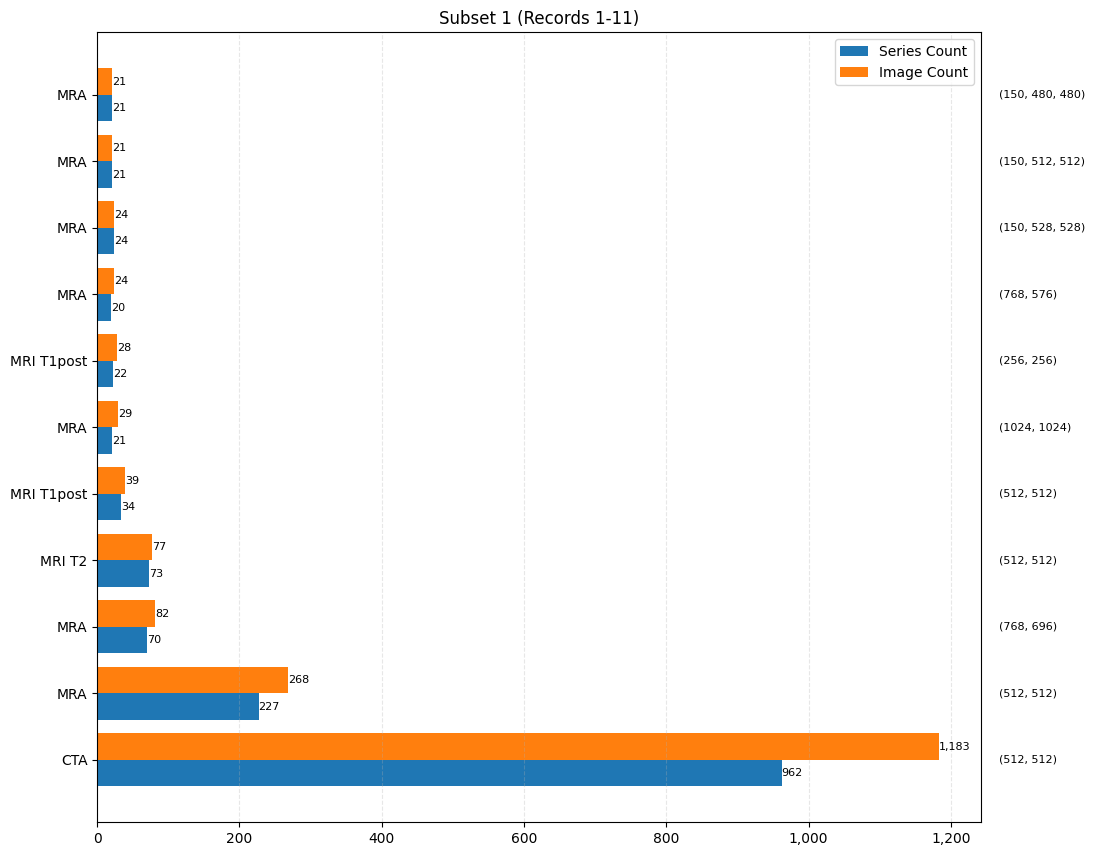

In [39]:
# Convert to pandas for easier plotting with matplotlib
pdf = grouped_df.to_pandas()

# Calculate number of subplots needed
records_per_plot = 30
total_records = len(pdf)
num_plots = (total_records + records_per_plot - 1) // records_per_plot  # Ceiling division

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 25))  # 3x2 grid for 6 subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Color scheme
series_color = '#1f77b4'  # Blue
images_color = '#ff7f0e'  # Orange

# Format numbers with comma as thousand separator
def format_number(x):
    return f'{int(x):,}'

# Plot each subset of data
for plot_idx in range(num_plots):
    ax = axes[plot_idx]
    
    # Get the slice of data for this subplot
    start_idx = plot_idx * records_per_plot
    end_idx = min(start_idx + records_per_plot, total_records)
    plot_data = pdf.iloc[start_idx:end_idx]
    
    # Create horizontal bars
    y_pos = np.arange(len(plot_data))
    
    # Plot series count
    series_bars = ax.barh(y_pos - 0.2, plot_data['total_series'], 
                         height=0.4, color=series_color, label='Series Count')
    
    # Plot image count
    image_bars = ax.barh(y_pos + 0.2, plot_data['total_images'], 
                        height=0.4, color=images_color, label='Image Count')
    
    # Customize the plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_data['Modality'])
    
    # Add value labels on the bars
    for bars in [series_bars, image_bars]:
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   format_number(width),
                   ha='left', va='center', fontsize=8)
    
    # Add shape information as text on the right side
    for idx, (shape, series, images) in enumerate(zip(plot_data['img_array_shape_tuple'], 
                                                     plot_data['total_series'],
                                                     plot_data['total_images'])):
        ax.text(1.02, idx, shape, transform=ax.get_yaxis_transform(),
                ha='left', va='center', fontsize=8)
    
    # Add legend only to the first subplot
    if plot_idx == 0:
        ax.legend()
    
    # Add title
    ax.set_title(f'Subset {plot_idx + 1} (Records {start_idx + 1}-{end_idx})')
    
    # Add grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Format x-axis with comma as thousand separator
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format_number(x)))

# Remove any empty subplots
for idx in range(num_plots, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def validate_aneurysm_data(df):
    """
    Validate that for each combination of SeriesInstanceUID, PatientAge, PatientSex, and Modality,
    exactly one of the aneurysm location columns has value 1 and the rest have value 0.
    
    Parameters:
    df (polars.DataFrame): DataFrame with the specified columns
    
    Returns:
    dict: Validation results including violations and summary statistics
    """
    
    # Define the grouping columns (first 4 columns)
    grouping_cols = ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality']
    
    # Define the aneurysm location columns (remaining 13 columns)
    aneurysm_cols = [
        'Left Infraclinoid Internal Carotid Artery',
        'Right Infraclinoid Internal Carotid Artery',
        'Left Supraclinoid Internal Carotid Artery',
        'Right Supraclinoid Internal Carotid Artery',
        'Left Middle Cerebral Artery',
        'Right Middle Cerebral Artery',
        'Anterior Communicating Artery',
        'Left Anterior Cerebral Artery',
        'Right Anterior Cerebral Artery',
        'Left Posterior Communicating Artery',
        'Right Posterior Communicating Artery',
        'Basilar Tip',
        'Other Posterior Circulation'
    ]
    
    # Check if 'Aneurysm Present' should be included in the validation
    #if 'Aneurysm Present' in df.columns:
    #    aneurysm_cols.append('Aneurysm Present')
    
    print(f"Validating {len(aneurysm_cols)} aneurysm location columns...")
    print(f"Aneurysm columns: {aneurysm_cols}")
    
    # Group by the first 4 columns and sum the aneurysm location columns
    grouped = df.group_by(grouping_cols).agg([
        pl.col(col).sum().alias(f"{col}_sum") for col in aneurysm_cols
    ])
    
    # Calculate the total sum for each group (should be 1 for valid records)
    sum_cols = [f"{col}_sum" for col in aneurysm_cols]
    grouped = grouped.with_columns([
        pl.sum_horizontal(sum_cols).alias('total_aneurysm_count')
    ])
    
    # Find violations (where total is not equal to 1)
    violations = grouped.filter(pl.col('total_aneurysm_count') != 1)
    
    # Separate different types of violations
    zero_violations = grouped.filter(pl.col('total_aneurysm_count') == 0)  # No aneurysm marked
    multiple_violations = grouped.filter(pl.col('total_aneurysm_count') > 1)  # Multiple aneurysms marked
    
    # Create summary statistics
    total_groups = grouped.height
    valid_groups = grouped.filter(pl.col('total_aneurysm_count') == 1).height
    invalid_groups = violations.height
    
    results = {
        'total_groups': total_groups,
        'valid_groups': valid_groups,
        'invalid_groups': invalid_groups,
        'validation_passed': invalid_groups == 0,
        'zero_violations': zero_violations.height,
        'multiple_violations': multiple_violations.height,
        'violations_data': violations,
        'zero_violations_data': zero_violations,
        'multiple_violations_data': multiple_violations
    }
    
    return results

def print_validation_summary(results):
    """Print a summary of the validation results."""
    print("\n" + "="*60)
    print("ANEURYSM DATA VALIDATION SUMMARY")
    print("="*60)
    
    print(f"Total unique combinations: {results['total_groups']}")
    print(f"Valid combinations: {results['valid_groups']}")
    print(f"Invalid combinations: {results['invalid_groups']}")
    print(f"Validation passed: {results['validation_passed']}")
    
    if results['invalid_groups'] > 0:
        print(f"\nTypes of violations:")
        print(f"- No aneurysm marked (sum = 0): {results['zero_violations']}")
        print(f"- Multiple aneurysms marked (sum > 1): {results['multiple_violations']}")
        
        print(f"\nValidation accuracy: {results['valid_groups']/results['total_groups']*100:.2f}%")

def show_violation_details(results, max_violations=10):
    """Show detailed information about violations."""
    
    if results['zero_violations'] > 0:
        print(f"\n{'='*40}")
        print("RECORDS WITH NO ANEURYSM MARKED (sum = 0)")
        print(f"{'='*40}")
        print(results['zero_violations_data'].head(max_violations))
    
    if results['multiple_violations'] > 0:
        print(f"\n{'='*40}")
        print("RECORDS WITH MULTIPLE ANEURYSMS MARKED (sum > 1)")
        print(f"{'='*40}")
        print(results['multiple_violations_data'].head(max_violations))

In [ ]:
results = validate_aneurysm_data(df_aneurysm_present)

In [ ]:
print_validation_summary(results)

In [ ]:
if results['invalid_groups'] > 0:
        show_violation_details(results)

In [ ]:
dd.sql("select * from df_aneurysm_present \
where SeriesInstanceUID = '1.2.826.0.1.3680043.8.498.74614921932700985358270443944241418147' ").pl()